In [1]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import math
import matplotlib.image as mpimg 
import os

In [47]:
def my_imfilter(pic,kernel,pad,convrr,alpha): #pic is input image, kernel is the desired kernel
    #pad is 0 for zero padding and 1 for reflected image
    #convrr is 0 for convolution and 1 for direct cross correlation
    #and alpha is a value from zero to one such that it represents a linear combination of the filter and original image
    if (kernel.shape[0] % 2 == 0) or (kernel.shape[1] % 2 == 0):
        print("Please provide kernel with odd dimensions")
    else:
        cutoffrow = math.ceil(kernel.shape[0]/2)-1 #this allows for dimension of filtering so as to not be out of bounds
        cutoffcol = math.ceil(kernel.shape[1]/2)-1
        l = len(pic[0][0]) #length of image pixel to determine grayscale or RBG
        picpad = pic.copy() #these will be the stored and modified values
        fil = pic.copy()
        newpic = pic.copy()
        if l == 1: #grayscale images
            if pad == 0: #this allows for zero padding
                for i in range(cutoffrow):
                    for j in range(pic.shape[1]):
                        picpad[i][j] = 0 
                for i in range(pic.shape[0]):
                    for j in range(cutoffcol):
                        picpad[i][j] = 0 
                for i in range(pic.shape[0]-cutoffrow,pic.shape[0]):
                    for j in range(pic.shape[1]):
                        picpad[i][j] = 0 
                for i in range(pic.shape[0]):
                    for j in range(pic.shape[1]-cutoffcol,pic.shape[1]):
                        picpad[i][j] = 0 
            else: #this allows for reflected images
                for i in range(cutoffrow):
                    for j in range(pic.shape[1]):
                        picpad[i][j] = pic[cutoffrow+1][j] 
                for i in range(pic.shape[0]):
                    for j in range(cutoffcol):
                        picpad[i][j] = pic[i][cutoffcol+1]
                for i in range(pic.shape[0]-cutoffrow,pic.shape[0]):
                    for j in range(pic.shape[1]):
                        picpad[i][j] = pic[pic.shape[0]-cutoffrow-1][j] 
                for i in range(pic.shape[0]):
                    for j in range(pic.shape[1]-cutoffcol,pic.shape[1]):
                        picpad[i][j] = pic[i][pic.shape[1]-cutoffcol-1]
            if convrr == 0: #cross correlation
                val = 5 #this is to start with value and preserved by substracting after operations
                for i in range(cutoffrow,pic.shape[0] - cutoffrow): #we apply linear filtering of the kernel across the image, ignoring edges
                    for j in range(cutoffcol,pic.shape[1]-cutoffcol):
                        for m in range(-cutoffrow,cutoffrow+1):
                            for n in range(-cutoffcol,cutoffcol+1):
                                val = val + kernel[-m][-n]*picpad[i-m][j-n] 
                        val = val - 5
                        fil[i][j] = abs(val)
                        newpic[i][j] = alpha*fil[i][j] + (1-alpha)*picpad[i][j] #linear combination of padded image and filter 
                        val = 5
            else:
                val = 5 #convolution
                for i in range(cutoffrow,pic.shape[0] - cutoffrow): #we apply linear filtering of the kernel across the image, ignoring edges
                    for j in range(cutoffcol,pic.shape[1]-cutoffcol):
                        for m in range(-cutoffrow,cutoffrow+1):
                            for n in range(-cutoffcol,cutoffcol+1):
                                val = val + kernel[-m][-n]*picpad[i+m][j+n]   
                        val = val - 5
                        fil[i][j] = abs(val)
                        newpic[i][j] = alpha*fil[i][j] + (1-alpha)*picpad[i][j]    
                        val = 5
        else: #same as grayscale but with vector values
            if pad == 0:
                for i in range(cutoffrow):
                    for j in range(pic.shape[1]):
                        picpad[i][j][0] = 0 
                        picpad[i][j][1] = 0
                        picpad[i][j][2] = 0
                for i in range(pic.shape[0]):
                    for j in range(cutoffcol):
                        picpad[i][j][0] = 0 
                        picpad[i][j][1] = 0
                        picpad[i][j][2] = 0
                for i in range(pic.shape[0]-cutoffrow,pic.shape[0]):
                    for j in range(pic.shape[1]):
                        picpad[i][j][0] = 0 
                        picpad[i][j][1] = 0
                        picpad[i][j][2] = 0
                for i in range(pic.shape[0]):
                    for j in range(pic.shape[1]-cutoffcol,pic.shape[1]):
                        picpad[i][j][0] = 0 
                        picpad[i][j][1] = 0
                        picpad[i][j][2] = 0
            else:
                for i in range(cutoffrow):
                    for j in range(pic.shape[1]):
                        picpad[i][j][0] = pic[cutoffrow+1][j][0] 
                        picpad[i][j][1] = pic[cutoffrow+1][j][1] 
                        picpad[i][j][2] = pic[cutoffrow+1][j][2] 
                for i in range(pic.shape[0]):
                    for j in range(cutoffcol):
                        picpad[i][j][0] = pic[i][cutoffcol+1][0] 
                        picpad[i][j][1] = pic[i][cutoffcol+1][1]
                        picpad[i][j][2] = pic[i][cutoffcol+1][2]
                for i in range(pic.shape[0]-cutoffrow,pic.shape[0]):
                    for j in range(pic.shape[1]):
                        picpad[i][j][0] = pic[pic.shape[0]-cutoffrow-1][j][0]  
                        picpad[i][j][1] = pic[pic.shape[0]-cutoffrow-1][j][1]
                        picpad[i][j][2] = pic[pic.shape[0]-cutoffrow-1][j][2]
                for i in range(pic.shape[0]):
                    for j in range(pic.shape[1]-cutoffcol,pic.shape[1]):
                        picpad[i][j][0] = pic[i][pic.shape[1]-cutoffcol-1][0] 
                        picpad[i][j][1] = pic[i][pic.shape[1]-cutoffcol-1][1]
                        picpad[i][j][2] = pic[i][pic.shape[1]-cutoffcol-1][2]
            if convrr == 0: #convolution
                val0 = 5
                val1 = 5
                val2 = 5
                for i in range(cutoffrow,picpad.shape[0] - cutoffrow): #we apply linear filtering of the kernel across the image, ignoring edges
                    for j in range(cutoffcol,picpad.shape[1]-cutoffcol):
                        for m in range(-cutoffrow,cutoffrow+1):
                            for n in range(-cutoffcol,cutoffcol+1):
                                val0 = val0 + kernel[-m][-n]*picpad[i+m][j+n][0]
                                val1 = val1 + kernel[-m][-n]*picpad[i+m][j+n][1]
                                val2 = val2 + kernel[-m][-n]*picpad[i+m][j+n][2] 
                        val0 = val0 - 5
                        val1 = val1 - 5
                        val2 = val2 - 5
                        fil[i][j][0] = abs(val0)
                        fil[i][j][1] = abs(val1)
                        fil[i][j][2] = abs(val2)
                        newpic[i][j][0] = alpha*fil[i][j][0] + (1-alpha)*picpad[i][j][0]    
                        newpic[i][j][1] = alpha*fil[i][j][1] + (1-alpha)*picpad[i][j][1]      
                        newpic[i][j][2] = alpha*fil[i][j][2] + (1-alpha)*picpad[i][j][2]      
                        val0 = 5
                        val1 = 5
                        val2 = 5
            else: #cross correlation
                val0 = 5
                val1 = 5
                val2 = 5
                for i in range(cutoffrow,picpad.shape[0] - cutoffrow): #we apply linear filtering of the kernel across the image, ignoring edges
                    for j in range(cutoffcol,picpad.shape[1]-cutoffcol):
                        for m in range(-cutoffrow,cutoffrow+1):
                            for n in range(-cutoffcol,cutoffcol+1):
                                val0 = val0 + kernel[-m][-n]*picpad[i-m][j-n][0]
                                val1 = val1 + kernel[-m][-n]*picpad[i-m][j-n][1]
                                val2 = val2 + kernel[-m][-n]*picpad[i-m][j-n][2] 
                        val0 = val0 - 5
                        val1 = val1 - 5
                        val2 = val2 - 5
                        fil[i][j][0] = abs(val0)
                        fil[i][j][1] = abs(val1)
                        fil[i][j][2] = abs(val2)
                        newpic[i][j][0] = alpha*fil[i][j][0] + (1-alpha)*picpad[i][j][0]    
                        newpic[i][j][1] = alpha*fil[i][j][1] + (1-alpha)*picpad[i][j][1]      
                        newpic[i][j][2] = alpha*fil[i][j][2] + (1-alpha)*picpad[i][j][2]      
                        val0 = 5
                        val1 = 5
                        val2 = 5
    return newpic, fil

In [455]:
kernel2 = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]) #this is our gradient x filter

In [8]:
kernel2 = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]]) #this is our gradient x filter

In [456]:
pic1 = mpimg.imread('food.jpeg') #we read original image
newpic = my_imfilter(pic1,kernel2,0,1,0.2)

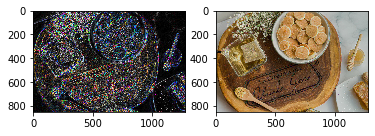

In [457]:
plt.subplot(1,2,1)
plt.imshow(newpic[1]) #filter pass
plt.subplot(1,2,2)
plt.imshow(newpic[0]) #filtered image

## Problem 2

In [404]:
pair1as = mpimg.imread('pair1a.png') #we read original image
pair1bs = mpimg.imread('pair1b.png')

In [405]:
pair1a = Image.open('pair1a.png') #we use this format to resize image
pair1b = Image.open('pair1b.png') 

In [78]:
def resizeimg(img1,img2,img1s,img2s):
    a = min(img1s.shape[0],img2s.shape[0])
    b = min(img1s.shape[1],img2s.shape[1])
    resize1 = img1.resize((a,b))
    resize2 = img2.resize((a,b))
    resize1.save('resize1.png')
    resize2.save('resize2.png')
    resize1 = mpimg.imread('resize1.png')
    resize2 = mpimg.imread('resize2.png')
    os.remove('resize1.png')
    os.remove('resize2.png')
    return resize1,resize2

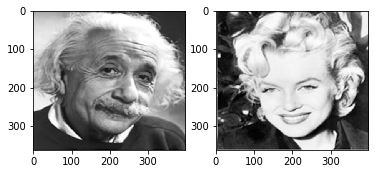

In [406]:
resize1 = resizeimg(pair1a,pair1b,pair1as,pair1bs)
pair1a = resize1[0]
pair1b = resize1[1]
plt.subplot(1,2,1)
plt.imshow(pair1a)
plt.subplot(1,2,2)
plt.imshow(pair1b)

In [66]:
lowpassker = np.array([[1/9,1/9,1/9],[1/9,1/9,1/9],[1/9,1/9,1/9]]) #low pass filter
highpassker = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]]) #High pass filter

In [67]:
lowpassfil = my_imfilter(pair1a,lowpassker,0,0,0.5) #we use convolution on the filter
highpassfil = my_imfilter(pair1b,highpassker,0,0,0.5)

In [68]:
lowpass = lowpassfil[1] #we preserve the filter
highpass = highpassfil[1]

In [362]:
def cutofffreq(img,alpha):
    cutimg = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            cutimg[i][j][0] = alpha*img[i][j][0]
            cutimg[i][j][1] = alpha*img[i][j][1]
            cutimg[i][j][2] = alpha*img[i][j][2]
    return cutimg

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


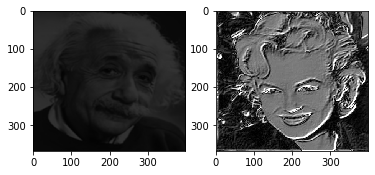

In [376]:
lowpassfreq = cutofffreq(lowpass,.2)
highpassfreq = cutofffreq(highpass,.5)
plt.subplot(1,2,1)
plt.imshow(lowpassfreq)
plt.subplot(1,2,2)
plt.imshow(highpassfreq)

In [95]:
def hyb(img1,img2,cutoff): #single cutoff
    hybridimg = img1.copy()
    for i in range(img1.shape[0]):
        for j in range(img2.shape[1]):
            hybridimg[i][j][0] = cutoff*img1[i][j][0] + (1-cutoff)*img2[i][j][0]
            hybridimg[i][j][1] = cutoff*img1[i][j][1] + (1-cutoff)*img2[i][j][1]
            hybridimg[i][j][2] = cutoff*img1[i][j][2] + (1-cutoff)*img2[i][j][2]
    return hybridimg

In [366]:
def hybadd(img1,img2): # straight addition
    hybridimg = img1.copy()
    for i in range(img1.shape[0]):
        for j in range(img2.shape[1]):
            hybridimg[i][j][0] = img1[i][j][0] + img2[i][j][0]
            hybridimg[i][j][1] = img1[i][j][1] + img2[i][j][1]
            hybridimg[i][j][2] = img1[i][j][2] + img2[i][j][2]
    return hybridimg

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


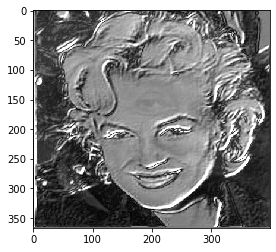

In [372]:
hybrid = hybadd(lowpassfreq,highpassfreq) #simple addition with respective cutoff
plt.imshow(hybrid) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


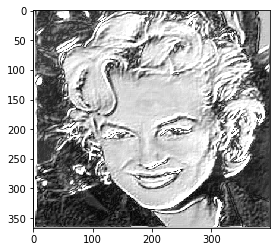

In [375]:
hybrid1 = hyb(lowpass,highpass,0.2) #cutoff total equal to 1
plt.imshow(hybrid1) 

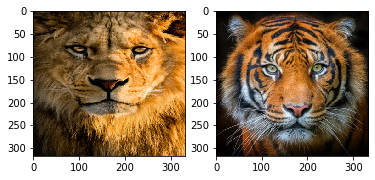

In [407]:
pair2as = mpimg.imread('pair2a.jpg') #we read original image
pair2bs = mpimg.imread('pair2b.png') #we read original image
pair2a = Image.open('pair2a.jpg') #we resize template image
pair2b = Image.open('pair2b.png') #we resize template image
resize2 = resizeimg(pair2a,pair2b,pair2as,pair2bs)
pair2a = resize2[0]
pair2b = resize2[1]
plt.subplot(1,2,1)
plt.imshow(pair2a)
plt.subplot(1,2,2)
plt.imshow(pair2b)

In [84]:
lowpassfil2 = my_imfilter(pair2a,lowpassker,0,0,0.5)
highpassfil2 = my_imfilter(pair2b,highpassker,0,0,0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


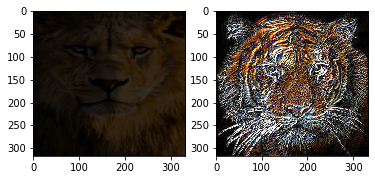

In [377]:
lowpass2 = lowpassfil2[1] #cutoff frequencies
highpass2 = highpassfil2[1]
lowpassfreq2 = cutofffreq(lowpass2,.2)
highpassfreq2 = cutofffreq(highpass2,.5)
plt.subplot(1,2,1)
plt.imshow(lowpassfreq2)
plt.subplot(1,2,2)
plt.imshow(highpassfreq2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


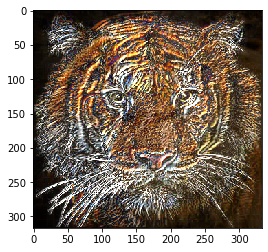

In [378]:
hybrid2 = hybadd(lowpassfreq2,highpassfreq2) #simple addition with respective cutoff
plt.imshow(hybrid2) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


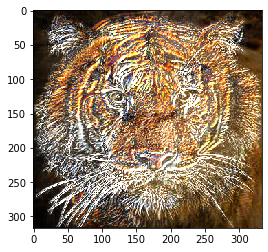

In [380]:
hybrid22 = hyb(lowpass2,highpass2,0.4)
plt.imshow(hybrid22) 

### Expression Change

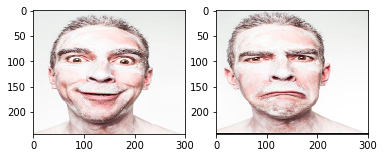

In [402]:
happys = mpimg.imread('happy.png') #we read original image
sads = mpimg.imread('sad.png') #we read original image
happy = Image.open('happy.png') #we resize template image
sad = Image.open('sad.png') #we resize template image
resize3 = resizeimg(happy,sad,happys,sads)
happy = resize3[0]
sad = resize3[1]
plt.subplot(1,2,1)
plt.imshow(happy)
plt.subplot(1,2,2)
plt.imshow(sad)

In [389]:
highpassker = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])

In [390]:
lowpassfil3 = my_imfilter(happy,lowpassker,0,0,0.5)
highpassfil3 = my_imfilter(sad,highpassker,0,0,0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


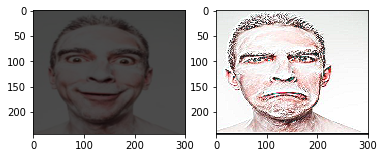

In [392]:
lowpass3 = lowpassfil3[1] #cutoff frequencies
highpass3 = highpassfil3[1]
lowpassfreq3 = cutofffreq(lowpass3,.3)
highpassfreq3 = cutofffreq(highpass3,.5)
plt.subplot(1,2,1)
plt.imshow(lowpassfreq3)
plt.subplot(1,2,2)
plt.imshow(passfreq3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


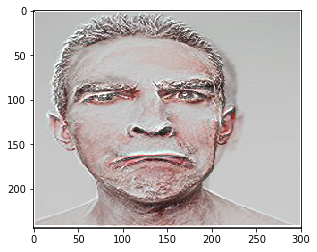

In [393]:
hybrid3 = hybadd(lowpassfreq3,highpassfreq3) #simple addition with respective cutoff
plt.imshow(hybrid3) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


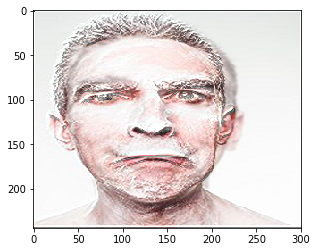

In [394]:
hybrid33 = hyb(lowpass3,highpass3,0.5)
plt.imshow(hybrid33) 

### Time Change

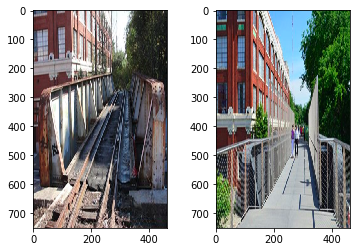

In [401]:
befores = mpimg.imread('before.png') #we read original image
afters = mpimg.imread('after.png') #we read original image
before = Image.open('before.png') #we resize template image
after = Image.open('after.png') #we resize template image
resize4 = resizeimg(before,after,befores,afters)
before = resize4[0]
after = resize4[1]
plt.subplot(1,2,1)
plt.imshow(before)
plt.subplot(1,2,2)
plt.imshow(after)

In [396]:
lowpassfil4 = my_imfilter(before,lowpassker,0,0,0.5)
highpassfil4 = my_imfilter(after,highpassker,0,0,0.5)

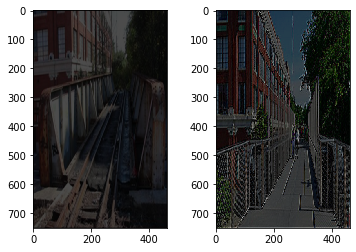

In [398]:
lowpass4 = lowpassfil4[1] #cutoff frequencies
highpass4 = highpassfil4[1]
lowpassfreq4 = cutofffreq(lowpass4,.3)
highpassfreq4 = cutofffreq(highpass4,.3)
plt.subplot(1,2,1)
plt.imshow(lowpassfreq4)
plt.subplot(1,2,2)
plt.imshow(highpassfreq4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


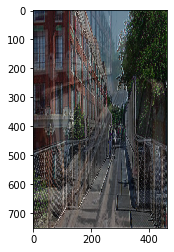

In [399]:
hybrid4 = hybadd(lowpassfreq4,highpassfreq4) #simple addition with respective cutoff
plt.imshow(hybrid4) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


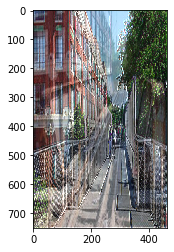

In [400]:
hybrid44 = hyb(lowpass4,highpass4,0.5)
plt.imshow(hybrid44) 

### Cutoff in the frequency domain

In [103]:
from scipy.fftpack import fft, fftfreq

In [252]:
def centf(img):
    imgneg = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            imgneg[i][j][0] = img[i][j][0]*(-1)**(i+j)
            imgneg[i][j][1] = img[i][j][1]*(-1)**(i+j)
            imgneg[i][j][2] = img[i][j][2]*(-1)**(i+j)
    return imgneg

In [408]:
lowpasskerc = lowpassker
for i in range(lowpassker.shape[0]):
    for j in range(lowpassker.shape[1]):
        lowpasskerc[i][j] = lowpassker[i][j]*(-1)**(i+j)
highpasskerc = highpassker
for i in range(highpassker.shape[0]):
    for j in range(highpassker.shape[1]):
        highpasskerc[i][j] = highpassker[i][j]*(-1)**(i+j)

In [409]:
kerlowf = np.fft.fft2(lowpasskerc) #kernels transformed to frequency domain
kerhighf= np.fft.fft2(highpasskerc)

In [410]:
pair2ac = centf(pair2a)
pair2bc = centf(pair2b)

In [411]:
pair2af = np.fft.fft2(pair2ac) #original image transformed to frequency domain
pair2bf = np.fft.fft2(pair2bc) #original image transformed to frequency domain

In [412]:
lowpassfil1f = my_imfilter(pair2af,kerlowf,0,0,0.5)
highpassfil1f = my_imfilter(pair2bf,kerlowf,0,0,0.5)

In [421]:
lowpassf = lowpassfil1f[0]
highpassf = highpassfil1f[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


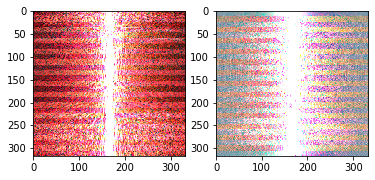

In [415]:
plt.subplot(1,2,1)
plt.imshow(np.log(1+np.abs(lowpassfil1f[0]))) 
plt.subplot(1,2,2)
plt.imshow(np.log(1+np.abs(highpassfil1f[0]))) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


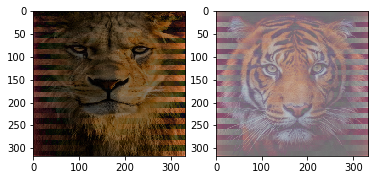

In [416]:
newlowpass = np.fft.ifft2(lowpassf)
newhighpass = np.fft.ifft2(highpassf)
plt.subplot(1,2,1)
plt.imshow(abs(newlowpass),"gray") 
plt.subplot(1,2,2)
plt.imshow(abs(newhighpass),"gray") 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


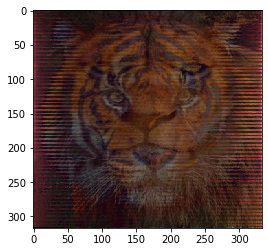

In [419]:
passedimg = pair2a.copy()
alpha = 0.5
for i in range(newlowpass.shape[0]):
    for j in range(newhighpass.shape[1]):
        pixelsuma = abs(newlowpass[i][j][0]) +abs(newlowpass[i][j][1])+abs(newlowpass[i][j][2])
        pixelsumb = abs(newhighpass[i][j][0]) +abs(newhighpass[i][j][1])+abs(newhighpass[i][j][2])
        if (pixelsuma != 0) and (pixelsumb != 0):
            passedimg[i][j][0] = alpha*abs(newlowpass[i][j][0]) + (1-alpha)*abs(newhighpass[i][j][0])
            passedimg[i][j][1] = alpha*abs(newlowpass[i][j][1]) + (1-alpha)*abs(newhighpass[i][j][1])
            passedimg[i][j][2] = alpha*abs(newlowpass[i][j][2]) + (1-alpha)*abs(newhighpass[i][j][2])
        else:
            passedimg[i][j][0] = abs(newlowpass[i][j][0]) + abs(newhighpass[i][j][0])
            passedimg[i][j][1] = abs(newlowpass[i][j][1]) + abs(newhighpass[i][j][1])
            passedimg[i][j][2] = abs(newlowpass[i][j][2]) + abs(newhighpass[i][j][2]) 
plt.imshow(abs(passedimg),"gray")

In [444]:
def cutofflow(img,freq): #using ideal lowpass filter
    cutofffil = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            #print(i)
            #print(j)
            D = math.sqrt((i-img.shape[0]/2)**2 + (j-img.shape[1]/2)**2)
            if D > freq:
                cutofffil[i][j][0] = 0
                cutofffil[i][j][1] = 0
                cutofffil[i][j][2] = 0
                cutofffil[i][j][3] = 0
            else:
                cutofffil[i][j][0] = 1
                cutofffil[i][j][1] = 1
                cutofffil[i][j][2] = 1
                cutofffil[i][j][3] = 1
    return cutofffil

In [443]:
def cutoffhigh(img,freq): #using highpass filter
    cutofffil = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            #print(i)
            D = math.sqrt((i-img.shape[0]/2)**2 + (j-img.shape[1]/2)**2)
            if D < freq:
                cutofffil[i][j][0] = 0
                cutofffil[i][j][1] = 0
                cutofffil[i][j][2] = 0
                cutofffil[i][j][3] = 0
            else:
                cutofffil[i][j][0] = 1
                cutofffil[i][j][1] = 1
                cutofffil[i][j][2] = 1
                cutofffil[i][j][3] = 1
    return cutofffil

In [434]:
lowpassfnew[0][0][0]

0j

In [445]:
pair1ac = centf(pair1a)
pair1bc = centf(pair1b)
pair1af = np.fft.fft2(pair1ac) #original image transformed to frequency domain
pair1bf = np.fft.fft2(pair1bc)

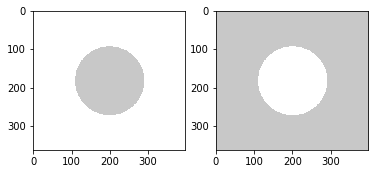

In [448]:
lowpassfnew = cutofflow(pair1af,90)
highpassfnew = cutoffhigh(pair1bf,90)
plt.subplot(1,2,1)
plt.imshow(np.log(1+np.abs(lowpassfnew))) 
plt.subplot(1,2,2)
plt.imshow(np.log(1+np.abs(highpassfnew))) 

In [449]:
def ftfilter(img,fil):
    filimg = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            filimg[i][j][0] = img[i][j][0]*fil[i][j][0]
            filimg[i][j][1] = img[i][j][1]*fil[i][j][1]
            filimg[i][j][2] = img[i][j][2]*fil[i][j][2]
            filimg[i][j][3] = img[i][j][3]*fil[i][j][3]
    return filimg

In [450]:
fillowpassf1a = ftfilter(pair1af,lowpassfnew)
filhighpassf1b = ftfilter(pair1bf,highpassfnew)

In [451]:
newlowpass = np.fft.ifft2(fillowpassf1a)
newhighpass = np.fft.ifft2(filhighpassf1b)

In [452]:
passedimg = pair1a.copy()
alpha = 0.5
for i in range(newlowpass.shape[0]):
    for j in range(newhighpass.shape[1]):
        pixelsuma = abs(newlowpass[i][j][0]) +abs(newlowpass[i][j][1])+abs(newlowpass[i][j][2])
        pixelsumb = abs(newhighpass[i][j][0]) +abs(newhighpass[i][j][1])+abs(newhighpass[i][j][2])
        if (pixelsuma != 0) and (pixelsumb != 0):
            passedimg[i][j][0] = alpha*abs(newlowpass[i][j][0]) + (1-alpha)*abs(newhighpass[i][j][0])
            passedimg[i][j][1] = alpha*abs(newlowpass[i][j][1]) + (1-alpha)*abs(newhighpass[i][j][1])
            passedimg[i][j][2] = alpha*abs(newlowpass[i][j][2]) + (1-alpha)*abs(newhighpass[i][j][2])
        else:
            passedimg[i][j][0] = abs(newlowpass[i][j][0]) + abs(newhighpass[i][j][0])
            passedimg[i][j][1] = abs(newlowpass[i][j][1]) + abs(newhighpass[i][j][1])
            passedimg[i][j][2] = abs(newlowpass[i][j][2]) + abs(newhighpass[i][j][2]) 

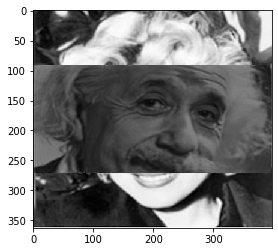

In [453]:
plt.imshow(passedimg)